In [28]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
from imageio import imread
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

%matplotlib widget

rng = np.random.default_rng(125)

In [2]:
# 2D design matrix
# omit y for a 1D design matrix
def DesignMatrix(p_order: int, x: npt.ArrayLike, y: npt.ArrayLike = None, intercept: bool = True) -> npt.NDArray:
    """
    Produce a Design matrix for linear regression for a given polynomial order in 1d or omit y for 2d

    Parameters:
        p_order (int): Order of polynomial
        x (ArrayLike): Array to be used in the Design matrix
        y (ArrayLike, optional): Add this parameter for 2d Design matrix, leave empty for 1d
        intercept (bool, optional): Wether the intercept should be included in the Design matrix, if False remove the first parameter
    """
    n = np.sum(range(p_order+2))
    
    if y.any() != None:
        X = np.ones((len(x), 1))
        for k in range(1, p_order+1):
            j = k
            i = 0
            while i < k + 1:
                X = np.column_stack((X, x**i*y**j))
                # if i == j:
                #     X = np.column_stack((X, x**i*y**j))
                # else:
                #     X = np.column_stack((X, x**i*y**j))
                #     X = np.column_stack((X, y**i*x**j))
                j -= 1
                i += 1
    
    else:
        X = np.ones((len(x), p_order+1))
        for i in range(1, p_order+1):
            X[:,i] = x**i

    if not intercept:
        X = np.delete(X, 0, 1)

    return X
    # 1                     #0
    # x,y                   #1
    # x²,y²,xy              #2
    # x³,y³,yx²,xy²         #3
    # x⁴,y⁴,yx³,xy³,x²y²    #4
    
    # 1,
    # 2, 2
    # 4, 4, 4
    # 8, 8, 8, 8
    # 16, 16, 16, 16, 16


def FrankeFunction(x: npt.ArrayLike, y: npt.ArrayLike, noise_factor: int=0) -> npt.NDArray:
    np.random.seed(125)
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + noise_factor*np.random.normal(0, 1, x.shape)


def R2(y_data: npt.ArrayLike, y_model: npt.ArrayLike) -> float:
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


def MSE(y_data: npt.ArrayLike,y_model: npt.ArrayLike) -> float:
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [3]:
def Plot(x, y, *z):
    n = len(z)
    fig, axs = plt.subplots(1, n, subplot_kw={"projection" : "3d"})

    for i in range(n):
        surf = axs[i].plot_surface(x, y, z[i], cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.legend()

    plt.show()


In [85]:
x = np.array([2])
y = np.array([3])
DesignMatrix(5, x, y, intercept=False)

array([[  3.,   2.,   9.,   6.,   4.,  27.,  18.,  12.,   8.,  81.,  54.,
         36.,  24.,  16., 243., 162., 108.,  72.,  48.,  32.]])

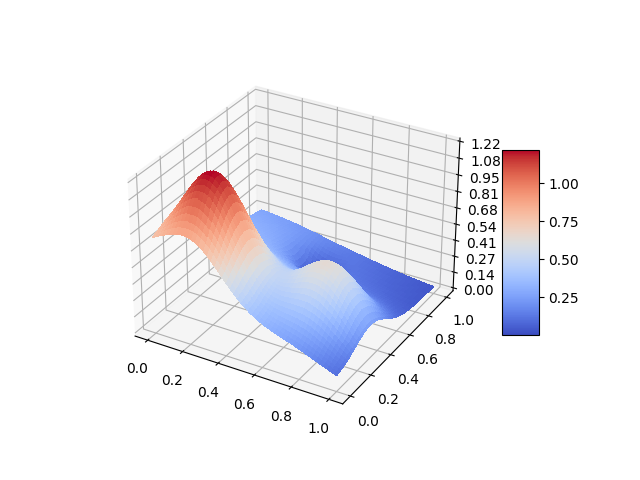

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection" : "3d"})

n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y, False)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Ordinary Linear Square Regression

Unscaled data
Training fit:
   MSE = 0.00034740921533360833 ; R2 = 0.9959637706799658
Test fit:
   MSE = 0.0006713272819340129 ; R2 = 0.9895554009536764

Scaled data
Training fit:
   MSE = 0.005319309294809085 ; R2 = 0.9946806907051909
Test fit:
   MSE = 0.012149092010587646 ; R2 = 0.9849946574091957


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


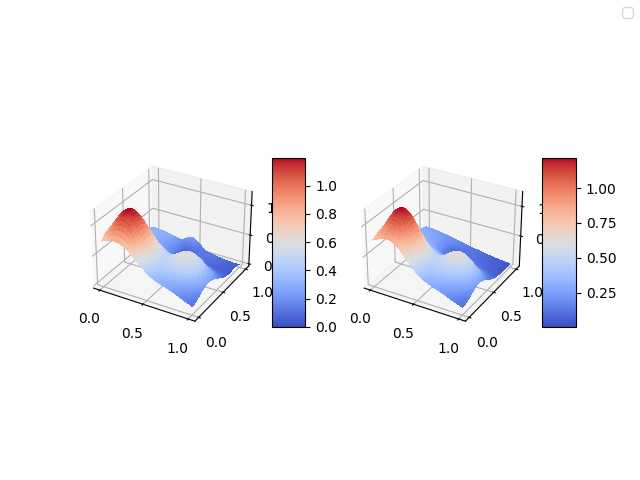

Text(0.5, 1.0, 'Real data')

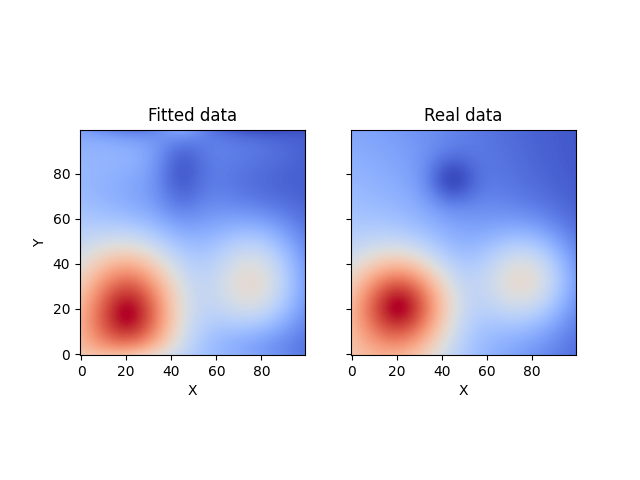

In [82]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, 0)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)


beta = (np.linalg.pinv(X_train.T @ X_train) @ X_train.T ) @ y_train
print('Unscaled data')
y_fit = X_train @ beta
print(f'Training fit:\n   MSE = {MSE(y_train, y_fit)} ; R2 = {R2(y_train, y_fit)}')

y_pred = X_test @ beta
print(f'Test fit:\n   MSE = {MSE(y_test, y_pred)} ; R2 = {R2(y_test, y_pred)}')

beta_scaled = (np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T ) @ y_train_scaled
print('\nScaled data')
y_fit_scaled = X_train_scaled @ beta_scaled
print(f'Training fit:\n   MSE = {MSE(y_train_scaled, y_fit_scaled)} ; R2 = {R2(y_train_scaled, y_fit_scaled)}')

y_pred_scaled = X_test_scaled @ beta_scaled
print(f'Test fit:\n   MSE = {MSE(y_test_scaled, y_pred_scaled)} ; R2 = {R2(y_test_scaled, y_pred_scaled)}')

Plot(x, y, X@beta, z)

fig, axs = plt.subplots(1,2, sharey=True, sharex=True)

axs[0].imshow(X@beta, cmap=cm.coolwarm, origin='lower')
axs[1].imshow(z, cmap=cm.coolwarm, origin='lower')
axs[0].set_xlabel('X')
axs[1].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[0].set_title('Fitted data')
axs[1].set_title('Real data')

## Ridge Regression

[[ 0.55676951  0.77646363  0.49626058 ... -0.03476886  0.2317854
   0.24086587]
 [ 0.49608999  0.62057991  0.9797193  ...  0.3896314   0.3422486
   0.35027868]
 [ 0.62084696  1.09375179  0.65744496 ...  0.05912351  0.19974728
   0.10672334]
 ...
 [ 0.07381922 -0.14876141  0.18761402 ...  0.54497821  0.12926009
  -0.48316601]
 [-0.09974022 -0.19234662  0.47010935 ...  0.00720639  0.56135264
   0.40413126]
 [-0.12461572 -0.21428205  1.0180887  ... -0.2695846   0.06693071
  -0.04128755]]


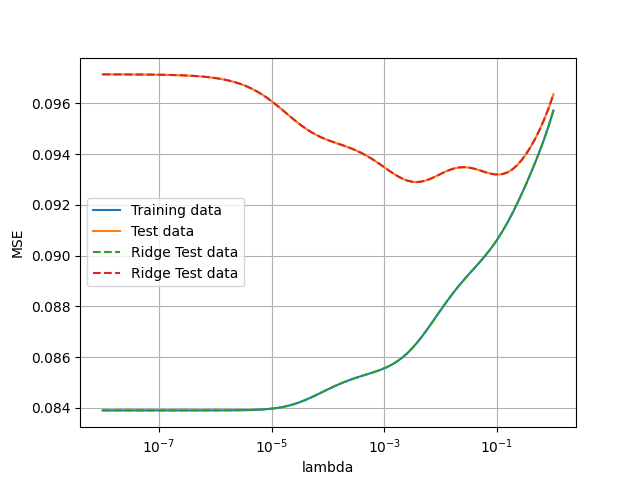

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


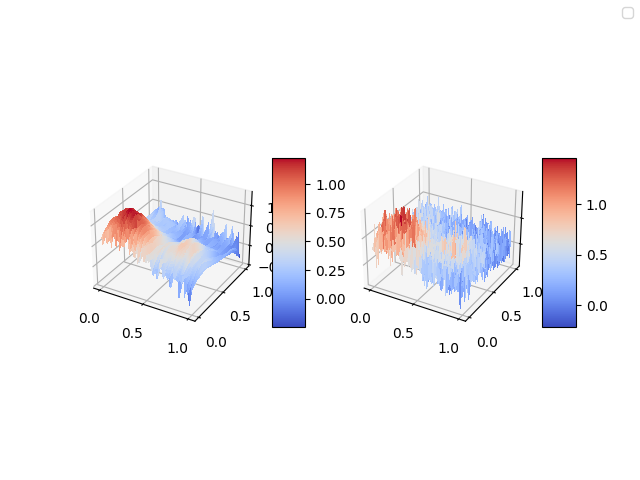

Text(0.5, 1.0, 'Real data')

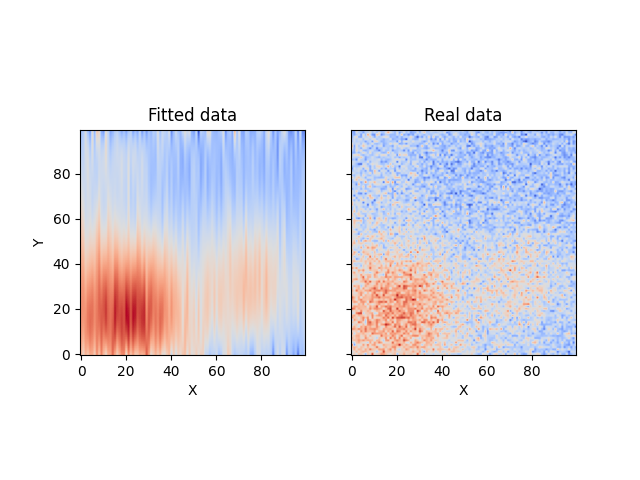

In [91]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, 0.3)
print(z)

p = X.shape[1]
I = np.eye(p, p)
lambdas = np.logspace(-8, 0, n)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# scaler.fit(y_train)
# y_train = scaler.transform(y_train)
# y_test = scaler.transform(y_test)

MSE_train = []
MSE_test = []
MSE_train_ridge = []
MSE_test_ridge = []
for lmb in lambdas:
    beta = np.linalg.pinv(X_train.T @ X_train + lmb*I) @ X_train.T @ y_train
    y_fit = X_train @ beta
    y_pred = X_test @ beta

    MSE_train.append(MSE(y_train, y_fit))
    MSE_test.append(MSE(y_test, y_pred))

    ridge = linear_model.Ridge(alpha=lmb, fit_intercept=False)
    ridge.fit(X_train, y_train)

    y_fit = ridge.predict(X_train)
    y_pred = ridge.predict(X_test)

    MSE_train_ridge.append(MSE(y_train, y_fit))
    MSE_test_ridge.append(MSE(y_test, y_pred))

    # print(f'Training fit:\n   MSE = {MSE(y_train, y_fit)} ; R2 = {R2(y_train, y_fit)}')
    # print(f'Test fit:\n   MSE = {MSE(y_test, y_pred)} ; R2 = {R2(y_test, y_pred)}')

plt.figure()

plt.plot(lambdas, MSE_train, label='Training data')
plt.plot(lambdas, MSE_test, label='Test data')
plt.plot(lambdas, MSE_train_ridge, label='Ridge Test data', linestyle='--')
plt.plot(lambdas, MSE_test_ridge, label='Ridge Test data', linestyle='--')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.grid()
plt.legend()

plt.show()

ridge = linear_model.Ridge(alpha=1e-4, fit_intercept=False)
ridge.fit(X_train, y_train)
beta = ridge.coef_
beta = np.swapaxes(beta, 0, 1)

y_fit = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

Plot(x, y, X@beta, z)

fig, axs = plt.subplots(1,2, sharey=True, sharex=True)

axs[0].imshow(X@beta, cmap=cm.coolwarm, origin='lower')
axs[1].imshow(z, cmap=cm.coolwarm, origin='lower')
axs[0].set_xlabel('X')
axs[1].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[0].set_title('Fitted data')
axs[1].set_title('Real data')

## Lasso Regression

/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.172e-01, tolerance: 3.073e-03
  model = cd_fast.enet_coordinate_descent(
/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-01, tolerance: 3.013e-03
  model = cd_fast.enet_coordinate_descent(
/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.082e-

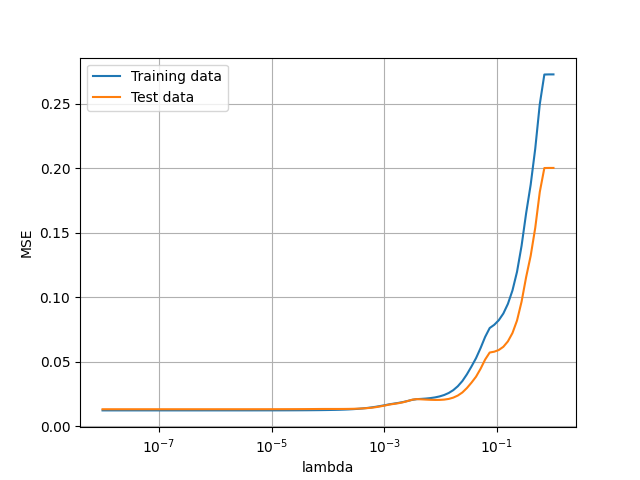

/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.172e-01, tolerance: 3.073e-03
  model = cd_fast.enet_coordinate_descent(
/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.251e-01, tolerance: 3.013e-03
  model = cd_fast.enet_coordinate_descent(
/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.082e-

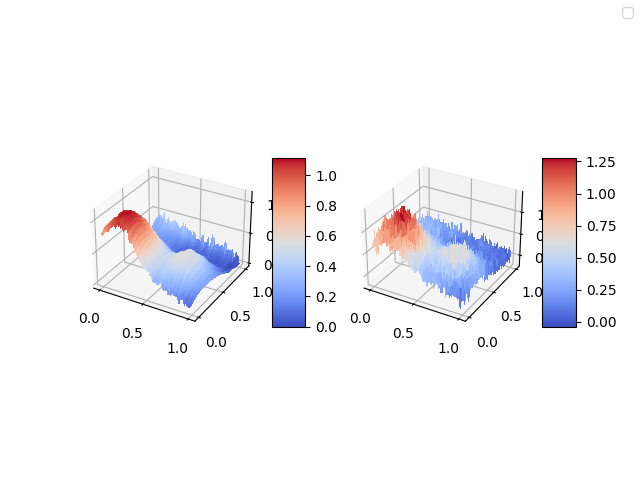

Text(0.5, 1.0, 'Real data')

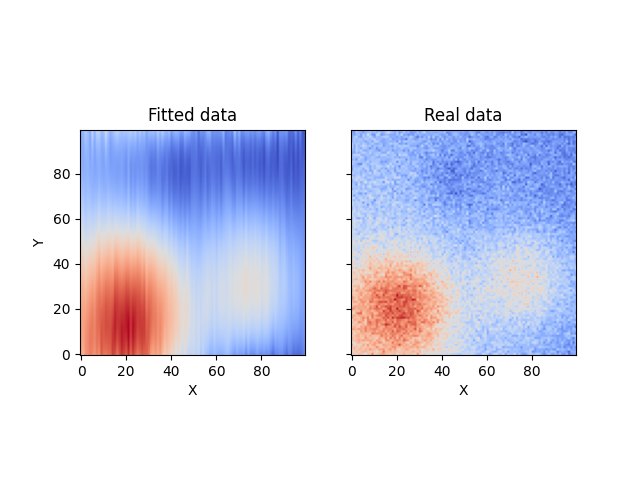

In [8]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, 0.1)

p = X.shape[1]
I = np.eye(p, p)
lambdas = np.logspace(-8, 0, 10)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

scaler = StandardScaler()
scaler.fit(X_train)

"""X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)"""

MSE_train = []
MSE_test = []
for lmb in lambdas:
    reg = linear_model.Lasso(lmb, fit_intercept=False)
    reg.fit(X_train, y_train)

    y_fit = reg.predict(X_train)
    y_pred = reg.predict(X_test)

    MSE_train.append(MSE(y_train, y_fit))
    MSE_test.append(MSE(y_test, y_pred))

    # print(f'Training fit:\n   MSE = {MSE(y_train, y_fit)} ; R2 = {R2(y_train, y_fit)}')
    # print(f'Test fit:\n   MSE = {MSE(y_test, y_pred)} ; R2 = {R2(y_test, y_pred)}')

plt.figure()

plt.plot(lambdas, MSE_train, label='Training data')
plt.plot(lambdas, MSE_test, label='Test data')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.grid()
plt.legend()

plt.show()

reg = linear_model.Lasso(lambdas[2], fit_intercept=False)
reg.fit(X_train, y_train)

beta = reg.coef_
beta = np.swapaxes(beta, 0, 1)

y_fit = reg.predict(X_train)
y_pred = reg.predict(X_test)

Plot(x, y, X@beta, z)

fig, axs = plt.subplots(1,2, sharey=True, sharex=True)

axs[0].imshow(X@beta, cmap=cm.coolwarm, origin='lower')
axs[1].imshow(z, cmap=cm.coolwarm, origin='lower')
axs[0].set_xlabel('X')
axs[1].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[0].set_title('Fitted data')
axs[1].set_title('Real data')

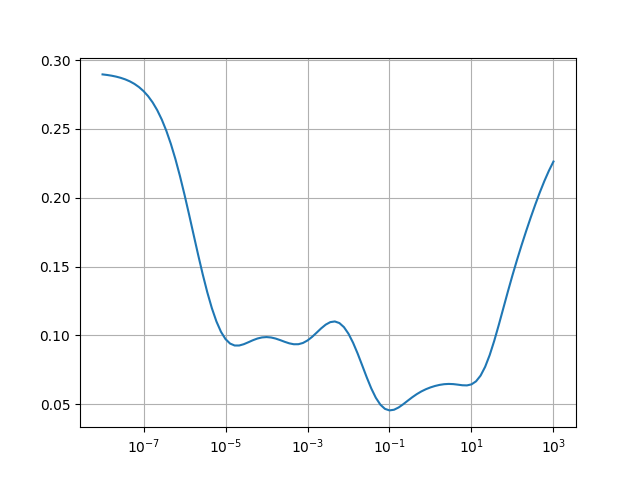

In [75]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, 0.1)

lambdas = np.logspace(-8, 3, n)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

k = 5
model = make_pipeline(
    #andardScaler(),
    linear_model.LinearRegression(fit_intercept=False),
    linear_model.Ridge(fit_intercept=False),
    linear_model.Lasso(fit_intercept=False),
    KFold(n_splits=k),
)

mse = []
for lmb in lambdas:
    ridge = model.named_steps['ridge'].set_params(alpha=lmb)
        
    cv = cross_val_score(ridge, X, z, scoring='neg_mean_squared_error', cv=k)
    # print(lmb, np.mean(-cv), cv)
    mse.append(np.mean(-cv))
    
plt.figure()

plt.plot(lambdas, mse)
plt.xscale('log')
plt.grid()

plt.show()

Best model:
   Best lambda: 1.00000e-01
   Best MSE:    0.04558
   CV score:    0.04558


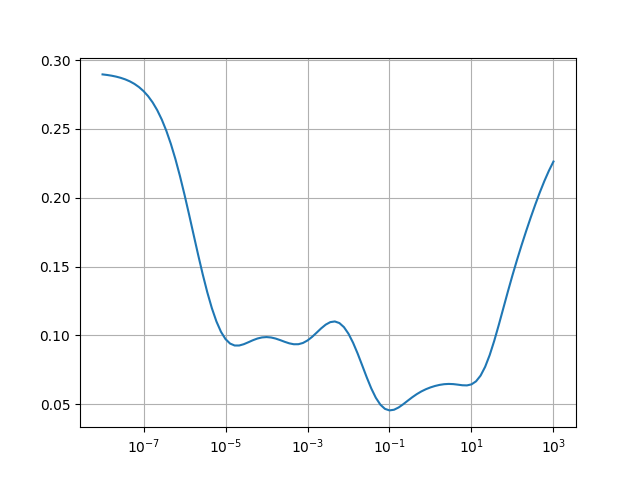

In [78]:
param_grid = {
    'alpha': np.logspace(-8, 3, n)
}

clf = GridSearchCV(linear_model.Ridge(fit_intercept=False), param_grid=param_grid, cv=k, scoring='neg_mean_squared_error', n_jobs=8)
clf.fit(X, z)

print('Best model:')
print(f'   Best lambda: {clf.best_params_["alpha"]:.5e}')
print(f'   Best MSE:    {-clf.best_score_:.5f}')
print(f'   CV score:    {-np.mean(cross_val_score(clf.best_estimator_, X, z, scoring="neg_mean_squared_error", cv=k)):.5f}')

# y_pred = clf.predict(X_test)

cv_results = clf.cv_results_
lambdas = cv_results['param_alpha']
mse = -cv_results['mean_test_score']

fig, ax = plt.subplots()

ax.plot(lambdas, mse)
ax.set_xscale('log')
ax.grid()


/tmp/ipykernel_100192/3808675080.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')
/tmp/ipykernel_100192/3808675080.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain2 = imread('SRTM_data_Norway_2.tif')


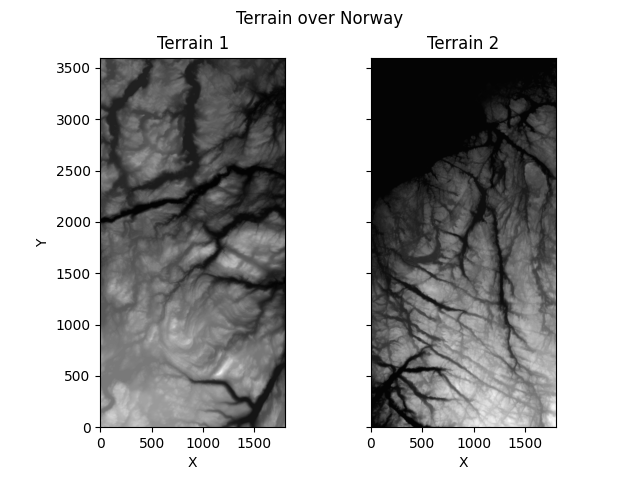

In [12]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig, axs = plt.subplots(1,2, sharey=True, sharex=True)

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
terrain2 = imread('SRTM_data_Norway_2.tif')
# Show the terrain
fig.suptitle('Terrain over Norway')
axs[0].imshow(terrain1, cmap='gray', origin='lower')
axs[1].imshow(terrain2, cmap='gray', origin='lower')
axs[0].set_xlabel('X')
axs[1].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[0].set_title('Terrain 1')
axs[1].set_title('Terrain 2')

plt.show()

In [13]:
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

Text(0.5, 1.0, 'Real data')

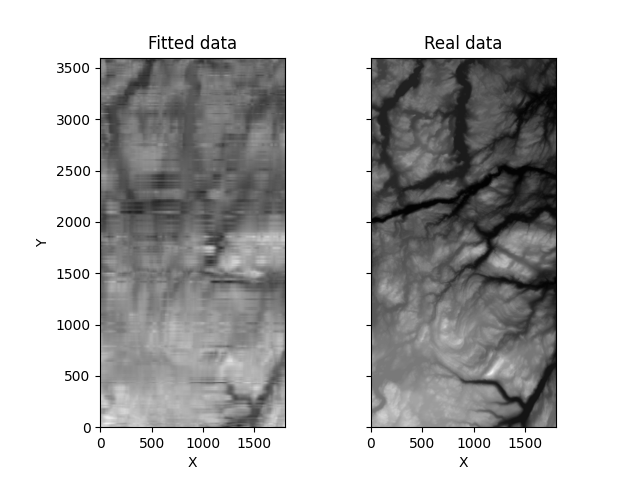

In [14]:
yn, xn = terrain1.shape
n = yn
p = 12

x = np.sort(rng.uniform(0, 1, n))
y = np.sort(rng.uniform(0, 1, n))

# x = np.arange(0, n, 1)
# y = np.arange(0, n, 1)

X = DesignMatrix(p, x, y)

X_train, X_test, y_train, y_test = train_test_split(X, terrain1, test_size=0.2, random_state=125)

scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)

# sklearn linear regression takes the second axis as features, sklearn will then make a new regression for each feature.
# Therefore when we input a 2d dataset we will make a new regression for each row
beta = np.swapaxes(reg.coef_, 0, 1)

fig, axs = plt.subplots(1,2, sharey=True, sharex=True)

axs[0].imshow(X @ beta, cmap='gray', origin='lower')
axs[1].imshow(terrain1, cmap='gray', origin='lower')
axs[0].set_xlabel('X')
axs[1].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[0].set_title('Fitted data')
axs[1].set_title('Real data')


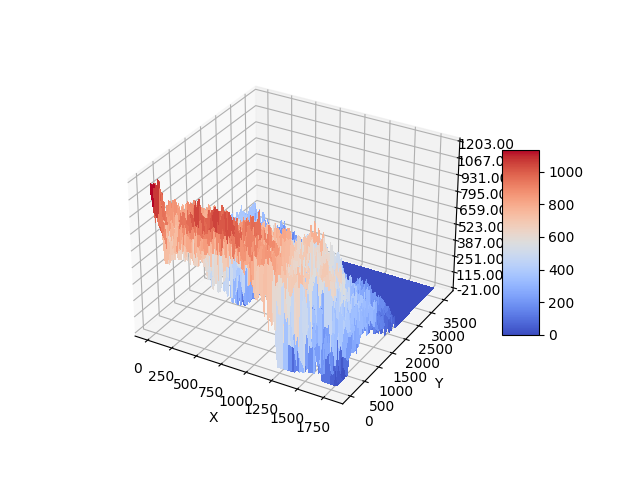

In [15]:
x = np.arange(0, terrain1.shape[0], 1)
y = np.arange(terrain1.shape[1], 0, -1)

x, y = np.meshgrid(y, x)

fig, ax = plt.subplots(subplot_kw={"projection" : "3d"})

# Plot the surface.
surf = ax.plot_surface(x, y, terrain2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('X')
ax.set_ylabel('Y')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()